# Exercise 4: Extended Kalman Filtering (EKF) for SLAM

https://github.com/AtsushiSakai/PythonRobotics/tree/master/SLAM/EKFSLAM

In this exercise you will:
- Learn about Extended Kalman Filtering for SLAM

As a first step, let's import the python modules we need.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from math import *
from IPython.display import display, clear_output

# pip install scipy (will also install "ipympl")
from scipy.spatial.transform import Rotation as Rot

### Simulation

<img width="400" height="300" src="../notebook_images/ekf_slam.png" style="padding-left: 10px; float: right;">

This simulation simulates a moving robot with a constant linear velocity and a constant angular velocity. There are also 4 landmarks that need to be mapped. In this simulation, an Extended Kalman Filter (EKF) is used to implement the SLAM algorithm.

In the figure to the right, the result of running the simulation is shown, where:
- Black stars: landmarks
- Green crosses: estimates of landmark positions
- Black line: dead reckoning
- Blue line: ground truth
- Red line: EKF SLAM position estimation

### Introduction

EKF SLAM models the SLAM problem in a single EKF where the modeled state $X$ is both the pose $(x, y, \theta)$ and an array of $n$ landmarks $[(x_1, y_1), (x_2, x_y), ..., (x_n, y_n)]$. The covariance $P$ between each of the positions and  landmarks are also tracked.

$$
X =
\begin{bmatrix}
x\\
y\\
\theta\\
x_1\\
y_1\\
x_2\\
y_2\\
\vdots\\
x_n\\
y_n
\end{bmatrix}

\;\;\;\;\;\;\;\;\;\;\;\;\;\;

P =
\begin{bmatrix}
\sigma_{xx} & \sigma_{xy} & \sigma_{x\theta} & \sigma_{xx_1} & \sigma_{xy_1} & \sigma_{xx_2} & \sigma_{xy_2} & \dots & \sigma_{xx_n} & \sigma_{xy_n}\\
\sigma_{yx} & \sigma_{yy} & \sigma_{y\theta} & \sigma_{yx_1} & \sigma_{yy_1} & \sigma_{yx_2} & \sigma_{yy_2} & \dots & \sigma_{yx_n} & \sigma_{yy_n}\\
\;\;\vdots & \;\;\vdots & \;\;\vdots & \;\;\vdots & \;\;\vdots & \;\;\vdots & \;\;\vdots & \ddots & \;\;\vdots & \;\;\vdots\\
\sigma_{y_nx} & \sigma_{y_ny} & \sigma_{y_n\theta} & \sigma_{y_nx_1} & \sigma_{y_ny_1} & \sigma_{y_nx_2} & \sigma_{y_ny_2} & \dots & \sigma_{y_nx_n} & \sigma_{y_ny_n}
\end{bmatrix}
$$

A single estimate of the pose is tracked over time, while the confidence in the pose is tracked by the covariance matrix $P$. $P$ is a symmetric square matrix, where each element in the matrix corresponds to the covariance between two state variables in the state vector. For example, $\sigma_{xy}$ represents the belief that the covariance between $x$ and $y$ is equal to $\sigma_{yx}$.

Initially, the Robot is placed in an unknown environment (i.e. there is no map of the environment). Therefore, the state vector and the state vector covariance matrix don't include any landmark positions:

$$
X =
\begin{bmatrix}
x\\
y\\
\theta
\end{bmatrix}

\;\;\;\;\;\;\;\;\;\;\;\;\;\;

P =
\begin{bmatrix}
\sigma_{xx} & \sigma_{xy} & \sigma_{x\theta}\\
\sigma_{yx} & \sigma_{yy} & \sigma_{y\theta}\\
\sigma_{\theta x} & \sigma_{\theta y} & \sigma_{\theta \theta}
\end{bmatrix}
$$

As landmarks are detected by the Robot, they are added to the state vector and the state covariance matrix. For example, when the Robot detects its first landmark $(x_1, y_1)$, the state vector and state covariance matrix would look like this:

$$
X =
\begin{bmatrix}
x\\
y\\
\theta\\
x_1\\
y_1
\end{bmatrix}

\;\;\;\;\;\;\;\;\;\;\;\;\;\;

P =
\begin{bmatrix}
\sigma_{xx} & \sigma_{xy} & \sigma_{x\theta} & \sigma_{xx_1} & \sigma_{xy_1}\\
\sigma_{yx} & \sigma_{yy} & \sigma_{y\theta} & \sigma_{yx_1} & \sigma_{yy_1}\\
\sigma_{\theta x} & \sigma_{\theta y} & \sigma_{\theta \theta} & \sigma_{\theta x_1} & \sigma_{\theta y_1}\\
\sigma_{x_1x} & \sigma_{x_1y} & \sigma_{x_1\theta} & \sigma_{x_1x_1} & \sigma_{x_1y_1}\\
\sigma_{y_1x} & \sigma_{y_1y} & \sigma_{y_1\theta} & \sigma_{y_1x_1} & \sigma_{y_1y_1}
\end{bmatrix}
$$

So, the only difference from EKF tracking, is that, in SLAM, we are tracking both the Robot's pose (localization) AND the landmarks (mapping).

---

Let's start by creating the covariance matrices $Q$ and $R$, and defining some input (control) noise $Q_{sim}$ and observation (measurement) noise $R_{sim}$.

We will also simulate the system in time increments of $0.1$ seconds, for a total of $50$ seconds.

$$
\textbf{Q} =
\begin{bmatrix}
0.5^2 & 0 & 0\\
0 & 0.5^2 & 0\\
0 & 0 & \frac{30\pi}{180}^2
\end{bmatrix}
$$

$$
\textbf{R} =
\begin{bmatrix}
0.5^2 & 0\\
0 & 0.5^2
\end{bmatrix}
$$

$$
\textbf{INPUT\_NOISE} =
\begin{bmatrix}
1.0^2 & 0\\
0 & \frac{10.0\pi}{180}^2
\end{bmatrix}
$$

$$
\textbf{OBSERVATION\_NOISE} =
\begin{bmatrix}
0.2^2 & 0\\
0 & \frac{\pi}{180}^2
\end{bmatrix}
$$

In [2]:
# EKF state and observation covariance
Q = np.diag([0.5, 0.5, np.deg2rad(30.0)])**2 # process noice covariance
R = np.diag([0.5, 0.5])**2 # observation noise covariance

#  Simulation parameters for noise
INPUT_NOISE = np.diag([1.0, np.deg2rad(10.0)])**2 # Control signal noise
OBSERVATION_NOISE = np.diag([0.2, np.deg2rad(1.0)])**2  # Sensor signal noise

# Time constant ("time tick") [s]
DT = 0.1  

# Total simulation time [s]
SIM_TIME = 50.0

# Maximum observation range (the robot can't see further than MAX_RANGE)
MAX_RANGE = 20.0

# Threshold of Mahalanobis distance for data association.
# We will only add a new landmark if it is at least
# M_DIST_TH units away from all known landmarks.
M_DIST_TH = 2.0

# The robot state size [x,y,yaw]
STATE_SIZE = 3

# The landmark state size [x,y]
LM_SIZE = 2

Next, let's create a function for the robot's motion model and its Jacobian matrix.

$
\begin{equation}
\textbf{x}_{t-1}=
\begin{bmatrix}
x_{t-1}\\
y_{t-1}\\
\theta_{t-1}
\end{bmatrix}
\end{equation}
$

$
\begin{equation}
\textbf{u}_t=
\begin{bmatrix}
v_t\\
\omega_t
\end{bmatrix}
\end{equation}
$

$
\begin{equation}
\textbf{F}=
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}
\end{equation}
$

$
\begin{equation}
\textbf{B}=
\begin{bmatrix}
cos(\theta)dt & 0\\
sin(\theta)dt & 0\\
0 & dt
\end{bmatrix}
\end{equation}
$

$
\begin{equation}
\textbf{x}_t = \textbf{F}\textbf{x}_{t-1} + \textbf{B}\textbf{u}_t =
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x_{t-1}\\
y_{t-1}\\
\theta_{t-1}
\end{bmatrix} +
\begin{bmatrix}
cos(\theta)dt & 0\\
sin(\theta)dt & 0\\
0 & dt
\end{bmatrix}
\begin{bmatrix}
v_t\\
\omega_t
\end{bmatrix} =
\begin{bmatrix}
x_{t-1} + v_t cos(\theta)dt\\
y_{t-1} + v_t sin(\theta)dt\\
\theta_{t-1} + \omega_t dt
\end{bmatrix}
\end{equation}
$

Since we have non-linear functions, we express the equation above as:

$$
\begin{equation}
\textbf{x}_t = f(\textbf{x}_{t-1}, \textbf{u}_t) = 

\begin{bmatrix}
x_{t-1} + v_t cos(\theta)dt\\
y_{t-1} + v_t sin(\theta)dt\\
\theta_{t-1} + \omega_t dt
\end{bmatrix}
\end{equation}
$$

Its Jacobian matrix is:

$$
\begin{equation}
\textbf{jF}_t =
\frac{\partial \textbf{f}}{\partial \textbf{x}}\Bigr|_{\substack{x_{t-1}, u_t}} =
\begin{bmatrix}
\frac{df_1}{dx} & \frac{df_1}{dy} & \frac{df_1}{d\theta}\\
\frac{df_2}{dx} & \frac{df_2}{dy} & \frac{df_2}{d\theta}\\
\frac{df_3}{dx} & \frac{df_3}{dy} & \frac{df_3}{d\theta}
\end{bmatrix}

=

\begin{bmatrix}
1 & 0 & -v sin(\theta)dt\\
0 & 1 & v cos(\theta)dt\\
0 & 0 & 1
\end{bmatrix}
\end{equation}
$$

In [3]:
def motion_model(x, u):
    """
    Computes the motion model based on the previous state vector and
    the current input control signal.
    
    :param x: 3x1 vector of the Robot's predicted pose [x; y; orientation] at the previous time step (t-1).
    :param u: 2x1 current control input vector [v; w]
    :returns: 3x1 vector of the Robot's predicted pose [x; y; orientation] at the current time step (t).

    Note:
    The state vector "x" does not contain the landmarks,
    since the landmarks don't move in THIS simulation.
    """
    F = np.array([[1.0, 0, 0],
                  [0, 1.0, 0],
                  [0, 0, 1.0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT]])

    x = (F @ x) + (B @ u)

    return x


def jacob_motion(x, u):
    """
    Calculates the jacobian of the motion model. 
    
    :param x: The state, including the estimated position of the system
    :param u: The input control signal
    :returns: jF: The Jacobian motion matrix,
               F: The motion (transition) matrix

    Note:
    The state vector "x" does not contain the landmarks,
    since the landmarks don't move in THIS simulation.
    """
    
    F = np.array([[1.0, 0, 0],
                  [0, 1.0, 0],
                  [0, 0, 1.0]])

    jF = np.array([[1.0, 0.0, -DT * u[0] * math.sin(x[2, 0])],
                   [0.0, 1.0, DT * u[0] * math.cos(x[2, 0])],
                   [0.0, 0.0, 1.0]], dtype='object')

    return jF, F

Let's also create a function for the robot's observation model and its Jacobian matrix.

In [4]:
def calc_innovation(lm, xEst, PEst, z, LMid):
    """
    Calculates the innovation (difference between the true sensor reading and
    the predicted sensor reading) based on expected robot position and landmark position.
    
    :param lm:   landmark position: 2x1 [x, y]
    :param xEst: estimated state vector
    :param PEst: estimated state covariance matrix
    :param z:    true sensor readings (measurements): 1x2 [distance, bearing]
    :param LMid: landmark id
    :returns:    returns the innovation y:  2x1 [delta_distance, delta_bearing],
                 the jacobian H (numerator) and matrix S (the denominator), used to calculate the Kalman Gain
    """
    
    # Calulate the predicted measurement zp
    # (i.e. the expected measurement based on xEst and the expected landmark position)

    # Calulate the range (distance) from the robot to the landmark
    delta = lm - xEst[0:2]      # vector: lm <---- robot: 2x1 [dx, dy]
    q = (delta.T @ delta)[0, 0] # dx**2 + dy**2
    distance = math.sqrt(q)     # sqrt(dx**2 + dy**2)

    # Calulate the bearing (angle) from the robot to the landmark
    zangle = pi_2_pi(math.atan2(delta[1, 0], delta[0, 0]) - xEst[2, 0])  # angle_robot_to_lm = lm_angle - robot_angle
    zp = np.array([[distance, zangle]]) # [distance, bearing]
    
    # Calculate the innovation y (i.e. true reading - predicted reading)    
    y = (z - zp).T        # 2x1 [delta_distance, delta_bearing]
    y[1] = pi_2_pi(y[1])
    
    # Calculate the jacobian observation matrix
    # (this is used in the numerator and denominator when calculating the Kalman Gain)
    H = jacobH(q, delta, xEst, LMid + 1)

    # Calculate the denominator used when calculating the Kalman Gain
    S = H @ PEst @ H.T + R

    # Return the innovation, denominator matrix and the numerator matrix
    # (jacobian observation matrix H), used to calculate the Kalman Gain
    return y, S, H


def jacobH(q, delta, x, i):
    """
    Calculates the jacobian of the observation (measurement) model.
    
    :param q:     the range (distance) from the robot's position to the landmark's position
    :param delta: the difference between a landmark position and the estimated system position
    :param x:     the state vector
    :param i:     landmark id + 1
    :returns:     the jacobian observation matrix H
    """

    # This function builds "assembles" the jacobian observation matrix H
    # based on how many landmarks are known at the moment.

    sq = math.sqrt(q) # distance to landmark
    G = np.array([[-sq * delta[0, 0], - sq * delta[1, 0], 0, sq * delta[0, 0], sq * delta[1, 0]],
                  [delta[1, 0], - delta[0, 0], - q, - delta[1, 0], delta[0, 0]]])
    G = G / q
    
    # Get the number of landmarks in the state vector
    nLM = calc_n_LM(x)

    F1 = np.hstack((np.eye(3), np.zeros((3, 2 * nLM))))
    F2 = np.hstack((np.zeros((2, 3)), np.zeros((2, 2 * (i - 1))),
                    np.eye(2), np.zeros((2, 2 * nLM - 2 * i))))

    F = np.vstack((F1, F2))

    H = G @ F

    return H

Now, let's define a function that returns the robot's control input.

$
\begin{equation}
\textbf{u}_t=
\begin{bmatrix}
v_t\\
\omega_t
\end{bmatrix}
\end{equation}
$

In [5]:
def get_control_input():
    '''
    There is no input to this function.
    The ouput is the constant linear velocity and the
    constant angular velocity for controlling the Robot.
    '''

    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]

    # Enter the velocities into a column vector
    u = np.array([[v, yawrate]]).T

    return u

Let's also define a function that reads the robot's sensors. For a real robot, we would only read and return the sensor readings, but in this simulation we are going to return:
- an observation of the Robot's true position (so we can compare this with the position estimated by the EKF).
- an observation of the Robot's *dead reckoning*, i.e. wihtout any Kalman Filtering.

In [6]:
def observation(xTrue, xd, u, RFID):
    """
    :param xTrue: the previous true state of the system
    :param xd:    the previous noisy estimate of the system (dead reckoning)
    :param u:     the current control input
    :param RFID:  the true position of the landmarks
    
    :returns:     Computes the current true position, current dead reckoning (noisy) position,
                  current noisy observations (measurements), and the current noisy control input.
    """
    
    # Calculate the current true state
    xTrue = motion_model(xTrue, u)

    # We will add noise to the beacon readings (distance, angle)
    z = np.zeros((0, 3))

    # Test all beacons, and only add the ones we can see (within MAX_RANGE)
    for i in range(len(RFID[:, 0])):

        # Calulate the range (distance) from the robot to the landmark
        dx = RFID[i, 0] - xTrue[0, 0]
        dy = RFID[i, 1] - xTrue[1, 0]
        d = math.sqrt(dx**2 + dy**2)
        
        # Calulate the bearing (angle) from the robot to the landmark
        angle = pi_2_pi(math.atan2(dy, dx) - xTrue[2, 0])
        
        # Only add beacons that the robot can see (within MAX_RANGE)
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * OBSERVATION_NOISE[0, 0]  # Add noise
            anglen = angle + np.random.randn() * OBSERVATION_NOISE[1, 1]  # Add noise
            zi = np.array([dn, anglen, i])
            z = np.vstack((z, zi))

    # Add noise to the control input
    ud = np.array([[
        u[0, 0] + np.random.randn() * INPUT_NOISE[0, 0],
        u[1, 0] + np.random.randn() * INPUT_NOISE[1, 1]]]).T

    # Calculate the current dead reckoning state
    # from the noisy control input signal.
    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

Now we can define a function for the Kalman filtering, i.e. for one iteration:

1. Predict
2. Update

At each time step, the following is done:
- predict the new state vector using the control input signal.
- update the belief in landmark positions based on the estimated state and measurements.

The control vector $\mathbf{u}=[v,\omega]^T$, consists of the a linear velocity $v$ and angular velocity $\omega$.

The predicted motion model **of the robot** (without any landmarks) would look like this: 

$
F =
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
\end{bmatrix}
$

We will have to add columns to this matrix, as landmark positions are added to the state vector.

The robot can also sense landmark beacons, if the robot is close enough to a landmark position.

In [7]:
def ekf_slam(xEst, PEst, u, z):
    """
    Performs an iteration of EKF SLAM from the available information. 
    
    :param xEst: the predicted state vector from the previous time step
    :param PEst: the predicted state covariance matrix from the previous time step
    :param u:    the control input signal for the current time step
    :param z:    the measurements (readings) for the current time step
    :returns:    the predicted state vector and state covariance matrix for the current time step
    """
    
    # Predict
    xEst, PEst = predict(xEst, PEst, u)

    # Update
    xEst, PEst = update(xEst, PEst, z)

    return xEst, PEst


def predict(xEst, PEst, u):
    """
    Performs the prediction step of EKF SLAM
    
    :param xEst: nx1 state vector from the previous time step
    :param PEst: nxn covariacne matrix from the previous time step
    :param u:    2x1 control input vector for the current time step
    :returns:    predicted state vector for the current time step,
                 predicted state covariance matrix for the current time step
    """
    S = STATE_SIZE
    jF, F = jacob_motion(xEst[0:S], u)
    xEst[0:S] = motion_model(xEst[0:S], u)
    
    # Fx is an an identity matrix of size (STATE_SIZE)
    PEst[0:S, 0:S] = jF.T @ PEst[0:S, 0:S] @ jF + F.T @ Q @ F
    
    return xEst, PEst


def update(xEst, PEst, z):
    """
    Performs the update step of EKF SLAM
    
    :param xEst:  nx1 predicted state vector for the current time step
    :param PEst:  nxn predicted state covariance matrix for the current time step
    :param z:     the measurements (readings) for the current time step
    :returns:     the corrected state and state covariance matrix for the current time step
    """
    
    for iz in range(len(z[:, 0])):  # For each observation
        minid = search_correspond_LM_ID(xEst, PEst, z[iz, 0:2]) # Associate to a known landmark

        nLM = calc_n_LM(xEst) # Number of landmarks we currently know about
        
        # If this is a NEW (previously unknown) landmark
        if minid == nLM: 
            # Extend the state vector and state covariance matrix (i.e. add the new landmark)
            xAug = np.vstack((xEst, calc_LM_Pos(xEst, z[iz, :])))           
            PAug = np.vstack((np.hstack((PEst, np.zeros((len(xEst), LM_SIZE)))),
                              np.hstack((np.zeros((LM_SIZE, len(xEst))), np.eye(2)))))
            xEst = xAug
            PEst = PAug
        
        # Get the landmark position [x; y] from the state vector
        lm = get_LM_Pos_from_state(xEst, minid)

        # Calulate the innovation
        y, S, H = calc_innovation(lm, xEst, PEst, z[iz, 0:2], minid)

        # Calculate the Kalman Gain
        K = (PEst @ H.T) @ np.linalg.inv(S)

        # Correct the current state vector and state covariance matrix
        xEst = xEst + (K @ y)
        PEst = (np.eye(len(xEst)) - (K @ H)) @ PEst
    
    # Keep the orientation (angle) within [0,2Pi].
    xEst[2] = pi_2_pi(xEst[2])

    # Return the corrected state vector and state covariance matrix
    return xEst, PEst

We also need a handful of utility funtions to manage angles and the landmarks.

In [8]:
def pi_2_pi(angle):
    '''
    Utility function to keep angles from growing to large, i.e. keeps angles within [0,2Pi].

    :param angle: the angle in radians (might be outside of [0,2Pi])
    :returns:     the angle in radians (within [0,2Pi])
    '''

    return (angle + math.pi) % (2 * math.pi) - math.pi


def calc_n_LM(x):
    """
    Calculates the number of landmarks currently tracked in the state vector.

    :param x: the state vector
    :returns: the number of landmarks n
    """
    n = int((len(x) - STATE_SIZE) / LM_SIZE)
    return n
    

def calc_LM_Pos(x, z):
    """
    Calcualtes the estimated position in the world coordinate frame
    of a landmark, given the measurement "z".

    :param x: [x; y; theta]
    :param z: [range; bearing]
    :returns: [x; y] for given measurement
    """
    zp = np.zeros((2, 1))

    zp[0, 0] = x[0, 0] + z[0] * math.cos(x[2, 0] + z[1])
    zp[1, 0] = x[1, 0] + z[0] * math.sin(x[2, 0] + z[1])
    
    return zp


def get_LM_Pos_from_state(x, ind):
    """
    Extracts the position of a given landmark from the state vector.
    
    :param x:   The state vector containing all landmark positions
    :param ind: landmark id
    :returns:   The position [x; y] of the landmark
    """
    lm = x[STATE_SIZE + LM_SIZE * ind: STATE_SIZE + LM_SIZE * (ind + 1), :]

    return lm


def search_correspond_LM_ID(xAug, PAug, zi):
    """
    Landmark association with Mahalanobis distance.
    
    If this landmark is at least M_DIST_TH units away from all known landmarks, 
    it is a NEW landmark.
    
    :param xAug: The estimated state vector
    :param PAug: The estimated covariance matrix
    :param zi:   the reading (measurement) of a specific landmark
    :returns:    landmark id
    """

    # Get the number of landmarks in the state vector
    nLM = calc_n_LM(xAug)

    # We will store the distances in this list
    mdist = []

    # Loop through all landmarks, calculate distances
    # and add them to the list of distances.
    for i in range(nLM):
        lm = get_LM_Pos_from_state(xAug, i)
        y, S, H = calc_innovation(lm, xAug, PAug, zi, i)
        mdist.append(y.T @ np.linalg.inv(S) @ y)

    # Add the minimum distance needed for a new
    # landmark to the lsit of distances.
    mdist.append(M_DIST_TH)

    # Find the index (landmark) of the minimum
    # distance in the list of distances.
    minid = mdist.index(min(mdist))

    # Return the index of the landmark with the minimum distance
    return minid

Finally, we can define a function to "drive" the simulation.

$
\begin{equation}
\textbf{x}_{0}=
\begin{bmatrix}
x_{0}\\
y_{0}\\
\theta_{0}
\end{bmatrix} =
\begin{bmatrix}
0\\
0\\
0
\end{bmatrix}
\end{equation}
$

$
\begin{equation}
\textbf{P}_0=
\begin{bmatrix}
\sigma^2_x & 0 & 0\\
0 & \sigma^2_y & 0\\
0 & 0 & \sigma^2_{\theta}
\end{bmatrix} =
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}
\end{equation}
$

In [9]:
def main():

    # The initial time step is t=0
    time = 0.0

    # RFID (landmark) positions [x, y]
    RFID = np.array([[10.0, -2.0],
                     [15.0, 10.0],
                     [3.0, 15.0],
                     [-5.0, 20.0]])

    # Initial state Vector [x y yaw]'
    # Let's set all the variables in the initial state vector to 0.
    xEst = np.zeros((STATE_SIZE, 1))  # This is really the only state vector we need for the EKF.
    xTrue = np.zeros((STATE_SIZE, 1)) # This state vector is only used to show the Robot's true trajectory.
    xDR = np.zeros((STATE_SIZE, 1))   # This state vector is only used to show the Robot's "dead reckoning" trajectory.

    # Initial state vector covariance matrix.
    # Let's set the initial covariance matrix to the identity matrix
    # (a variance of 1 for all state vector variables).
    PEst = np.eye(STATE_SIZE)

    # We will keep a history of the three state vectors,
    # so that we can plot this for each time step.
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue

    # Let's create a figure, in which we can animate the Robot's trajectory.
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)

    # Simulate the system for 50 seconds, using a time step of 0.1 seconds
    while SIM_TIME >= time:

        # Increment the time for this time step
        time += DT

        # Get the control input signal
        u = get_control_input()

        # Make an observation (i.e. read sensors, etc.)
        xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)

        # Perform one step of EKF SLAM
        xEst, PEst = ekf_slam(xEst, PEst, ud, z)


        print(xEst.shape)
        print(PEst.shape)

        # Extract the Robot's pose from the state vector
        x_state = xEst[0:STATE_SIZE]

        # Store the predicted state vectors in our history
        hxEst = np.hstack((hxEst, x_state))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))

        # Show an animation of the system's state
        
        ax.cla()

        # Plot the landmarks' true positions
        ax.plot(RFID[:, 0], RFID[:, 1], "*k")

        # Plot the Robot's estimated position
        ax.plot(xEst[0], xEst[1], ".r")

        # Plot the landmarks' estimated positions
        for i in range(calc_n_LM(xEst)):
            ax.plot(xEst[STATE_SIZE + i * 2],
                        xEst[STATE_SIZE + i * 2 + 1], "xg")

        # Plot the Robot's history of positions
        # (true, dead reckoning, EKF localization estimate)
        ax.plot(hxTrue[0, :],
                    hxTrue[1, :], "-b")
        ax.plot(hxDR[0, :],
                    hxDR[1, :], "-k")
        ax.plot(hxEst[0, :],
                    hxEst[1, :], "-r")
        
        ax.axis('square')
        ax.grid(True)

        display(fig)    
        clear_output(wait = True)
        plt.pause(0.001)

Now, let's run the simulation.

(11, 1)
(11, 11)


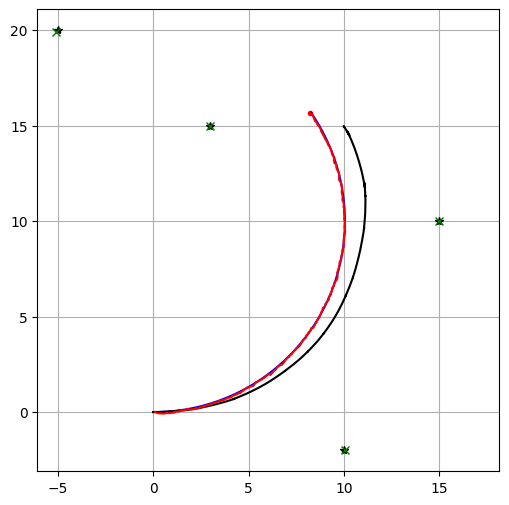

In [10]:
# Run simulation
main()

https://www.kalmanfilter.net/book.html